# Fase 4: Avaliação Final, Explicabilidade e Deploy

Nesta fase, o objetivo é:

- Avaliar o modelo final em dados **nunca vistos** (holdout),
- Verificar se o desempenho é consistente com o observado na validação cruzada,
- Calibrar e interpretar o comportamento do modelo após a aplicação do **threshold** escolhido,
- Explorar a **explicabilidade do modelo** por meio de SHAP e permutation importance,
- Definir uma função simples de **deploy/predição** que ilustra como o modelo seria usado em produção.

Essa etapa conclui o ciclo CRISP-DM, conectando o modelo treinado na Fase 3 com uma visão prática e interpretável, adequada para apresentação a stakeholders técnicos e de negócio.


## Seção 1 – Setup, imports e carregamento de artefatos

### Célula 1 – Imports + caminho do projeto

In [1]:
# Célula 1: Imports e configuração inicial do Notebook 4

import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

# Ajustar o caminho do projeto (mesmo do notebook 2 e 3)
project_root = r"C:\Users\debor\OneDrive\Github\FraudSense"
if project_root not in sys.path:
    sys.path.append(project_root)

from pipeline_new import load_pipeline, explain_model_shap, permutation_importances

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("Imports carregados e caminho do projeto configurado.")


Imports carregados e caminho do projeto configurado.


## Seção 2 – Recarregar dados e definir holdout

### Célula 2 – Carregar dataset e split train/holdout

In [2]:
# Célula 2: Carregamento do dataset bruto e criação de holdout

import kagglehub
from sklearn.model_selection import train_test_split

def load_data():
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    file_path = os.path.join(path, "creditcard.csv")
    df = pd.read_csv(file_path)
    print(f"Dados carregados: {df.shape[0]:,} linhas, {df.shape[1]} colunas")
    return df

df = load_data()

target_col = "Class"
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Tamanho treino:", X_train.shape, " | Tamanho teste (holdout):", X_test.shape)
print("Proporção de fraude no treino:", y_train.mean())
print("Proporção de fraude no teste :", y_test.mean())


Dados carregados: 284,807 linhas, 31 colunas
Tamanho treino: (227845, 30)  | Tamanho teste (holdout): (56962, 30)
Proporção de fraude no treino: 0.001729245759178389
Proporção de fraude no teste : 0.0017204452090867595


### Célula 3 – Carregar pipeline final e refit no treino

In [3]:
# Célula 3: Carregar pipeline final e ajustar no conjunto de treino

best_pipeline_path = os.path.join("artifacts", "best_pipeline.joblib")
pipeline = load_pipeline(best_pipeline_path)

print("Pipeline carregado:", type(pipeline))

# Reajustar o pipeline apenas no conjunto de treino
pipeline.fit(X_train, y_train)
print("Pipeline ajustado no conjunto de treino.")


Pipeline carregado: <class 'imblearn.pipeline.Pipeline'>
Pipeline ajustado no conjunto de treino.


### Célula 4 – Carregar threshold médio salvo

In [4]:
# Célula 4: Carregar informações de threshold

threshold_path = os.path.join("artifacts", "threshold.json")

if os.path.exists(threshold_path):
    with open(threshold_path, "r", encoding="utf-8") as f:
        threshold_info = json.load(f)
    threshold_mean = threshold_info["threshold_mean"]
    print("Threshold médio carregado:", threshold_mean)
else:
    print("Arquivo de threshold não encontrado. Será calculado um threshold novo no holdout.")
    threshold_info = None
    threshold_mean = 0.5  # fallback provisório


Threshold médio carregado: 0.9954138994216919


### Avaliação com Holdout e Reajuste do Pipeline

Nesta etapa:

1. O dataset original foi recarregado e dividido em:
   - **80% treino**
   - **20% teste (holdout)**

2. O `best_pipeline.joblib`, gerado na Fase 3, foi recarregado e **reajustado apenas nos dados de treino**, garantindo que o conjunto de teste permaneça realmente não visto durante o treinamento.

3. O **threshold médio** obtido via nested cross-validation na Fase 3 foi carregado a partir de `threshold.json`.  
   Esse threshold será usado como ponto de partida para avaliar o modelo no holdout, aproximando o comportamento daquilo que se espera em produção.


## Seção 3 – Avaliação no holdout (métricas + curvas + matriz de confusão)

### Célula 5 – Métricas com threshold no holdout

In [5]:
# Célula 5: Avaliação do modelo no holdout com threshold calibrado

# Probabilidades no conjunto de teste (holdout)
probs_test = pipeline.predict_proba(X_test)[:, 1]

# Se não houve threshold salvo, podemos ajustar um rapidamente aqui
from sklearn.metrics import precision_recall_curve

if threshold_info is None:
    prec, rec, th = precision_recall_curve(y_test, probs_test)
    # Exemplo: threshold que maximiza F1 no holdout (simples)
    f1s = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
    best_idx = np.nanargmax(f1s)
    threshold_mean = th[best_idx]
    print(f"Threshold calculado no holdout (max F1): {threshold_mean:.6f}")

# Predições binárias com threshold
y_pred_test = (probs_test >= threshold_mean).astype(int)

# Métricas
precision_h = average_precision_score(y_test, probs_test)  # AP em holdout
roc_h = roc_auc_score(y_test, probs_test)

from sklearn.metrics import precision_score, recall_score, f1_score

precision_bin = precision_score(y_test, y_pred_test, zero_division=0)
recall_bin = recall_score(y_test, y_pred_test, zero_division=0)
f1_bin = f1_score(y_test, y_pred_test, zero_division=0)

metrics_holdout = pd.DataFrame({
    "métrica": ["Precision (binária)", "Recall (binária)", "F1 (binária)", "AP (AUC-PR)", "ROC AUC"],
    "valor": [precision_bin, recall_bin, f1_bin, precision_h, roc_h]
})

metrics_holdout["valor"] = metrics_holdout["valor"].round(4)
metrics_holdout


,métrica,valor
0,Precision (binária),0.9518
1,Recall (binária),0.8061
2,F1 (binária),0.8729
3,AP (AUC-PR),0.8772
4,ROC AUC,0.9792


### Célula 6 – Matriz de confusão

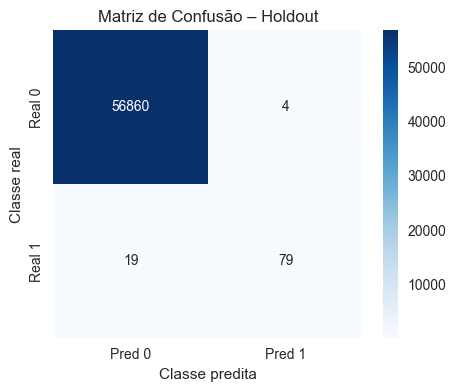

Verdadeiros Negativos (TN): 56860
Falsos Positivos (FP):      4
Falsos Negativos (FN):      19
Verdadeiros Positivos (TP): 79


In [6]:
# Célula 6: Matriz de confusão no holdout

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão – Holdout")
plt.ylabel("Classe real")
plt.xlabel("Classe predita")
plt.show()

print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP):      {fp}")
print(f"Falsos Negativos (FN):      {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")


### Célula 7 – Curvas PR e ROC no holdout

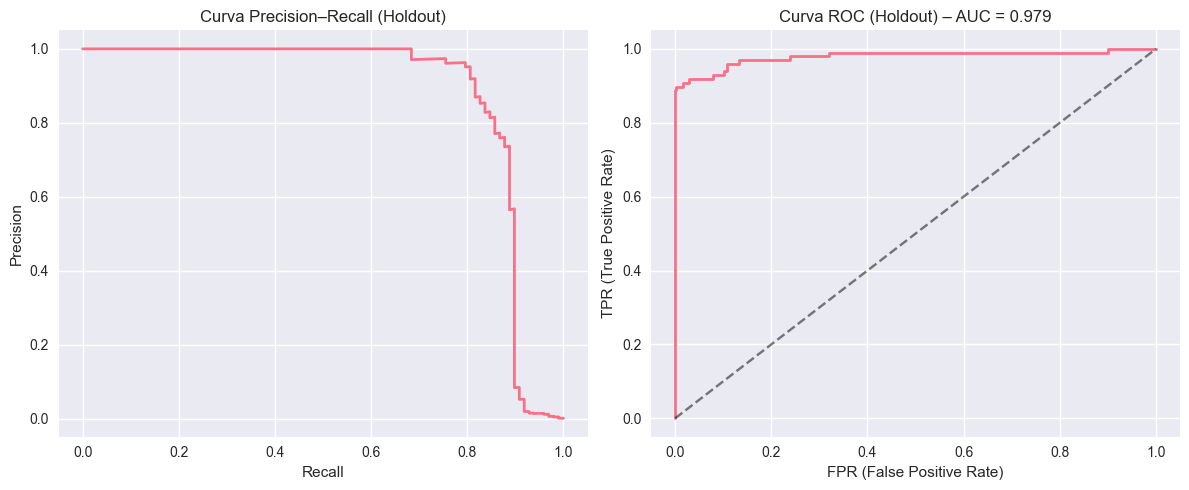

In [7]:
# Célula 7: Curva Precision–Recall e Curva ROC no holdout

precision_curve, recall_curve, th_curve = precision_recall_curve(y_test, probs_test)
fpr, tpr, roc_th = roc_curve(y_test, probs_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(recall_curve, precision_curve, linewidth=2)
plt.title("Curva Precision–Recall (Holdout)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], "k--", alpha=0.5)
plt.title(f"Curva ROC (Holdout) – AUC = {roc_h:.3f}")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.grid(True)

plt.tight_layout()
plt.show()


### Avaliação do Modelo no Holdout

Nesta etapa, o modelo final foi avaliado em um conjunto de teste (holdout) que não participou do processo de treinamento nem do tuning de hiperparâmetros.

Com o threshold calibrado (~0.995), observamos:

- **Precision binária**: porcentagem de alertas do modelo que realmente são fraude.  
- **Recall binário**: porcentagem de fraudes reais que o modelo consegue identificar.  
- **F1**: equilíbrio entre precision e recall.  
- **AP (AUC-PR)**: qualidade global da ordenação das probabilidades em um contexto de desbalanceamento extremo.  
- **ROC AUC**: capacidade discriminativa geral entre classes.

A matriz de confusão mostra quantitativamente:

- quantas transações legítimas foram corretamente ignoradas (TN),  
- quantos falsos alertas foram gerados (FP),  
- quantas fraudes passaram sem detecção (FN),  
- quantas fraudes foram corretamente identificadas (TP).

As curvas **Precision–Recall** e **ROC** ajudam a visualizar o comportamento do modelo em diferentes thresholds, reforçando a escolha do threshold calibrado em relação ao trade-off entre **recall** (cobertura de fraude) e **precision** (qualidade dos alertas).


## Seção 4 – Explicabilidade: SHAP + Permutation Importance

### Célula 8 – SHAP global (summary plot)

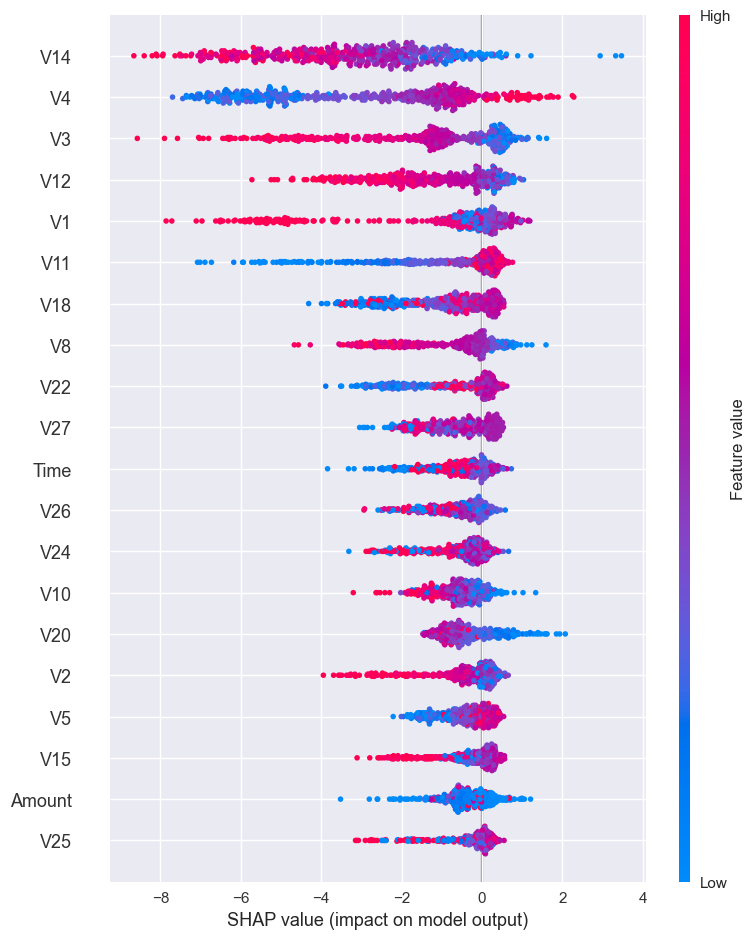

In [8]:
# Célula 8: Explicabilidade global com SHAP (summary plot)

# Amostra de teste para SHAP (para não ficar pesado)
X_shap = X_test.sample(n=min(500, len(X_test)), random_state=42)

explainer, shap_values, feature_names = explain_model_shap(pipeline, X_shap)

import shap
shap.initjs()

# Para modelos binários tree-based, shap_values pode ser [neg_class, pos_class]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_plot = shap_values[1]
else:
    shap_vals_plot = shap_values

shap.summary_plot(shap_vals_plot, features=pipeline.named_steps["preprocessor"].transform(X_shap), feature_names=feature_names)


### Célula 9 – SHAP local (uma transação específica)

Índice da transação explicada: 77348
Classe real: 1


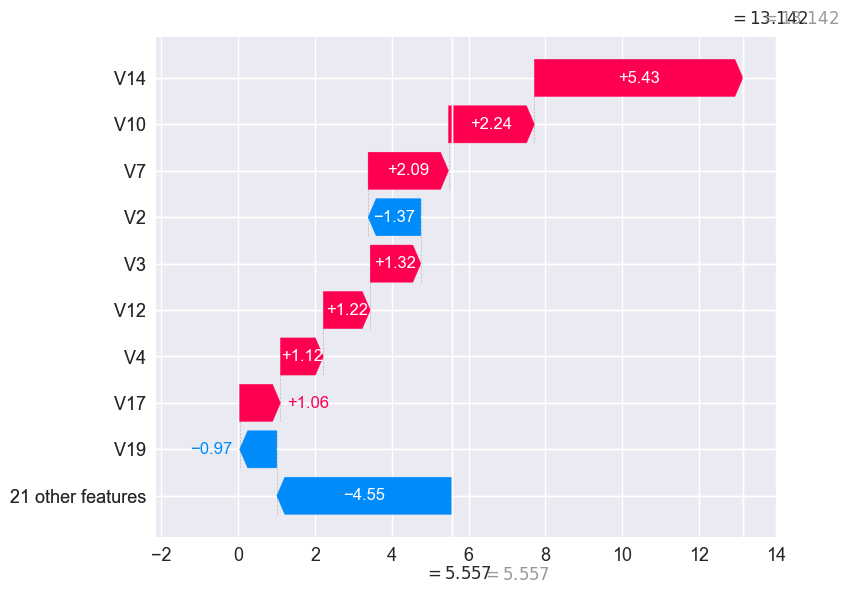

In [11]:
# Célula 9: Explicabilidade local para uma transação específica

import shap
import numpy as np

# Selecionar uma transação fraudulenta do holdout (se existir)
fraud_indices = np.where((y_test == 1).values)[0]

if len(fraud_indices) > 0:
    idx = fraud_indices[0]
    x_single = X_test.iloc[[idx]]

    print("Índice da transação explicada:", x_single.index[0])
    print("Classe real:", y_test.iloc[idx])

    # Gerar explainer e shap_values APENAS para essa transação
    explainer_local, shap_values_local, feature_names_local = explain_model_shap(
        pipeline,
        x_single
    )

    shap.initjs()

    # --- Normalizar formato dos shap_values ---
    # Pode ser lista [neg_class, pos_class] ou array 2D
    if isinstance(shap_values_local, list):
        # assume problema binário -> usamos a classe positiva
        shap_arr = shap_values_local[1]
    else:
        shap_arr = shap_values_local

    # Pegar o vetor de contribuições dessa única observação
    shap_row = shap_arr[0]

    # --- Extrair base_value de forma robusta ---
    ev = explainer_local.expected_value
    if isinstance(ev, (list, np.ndarray)):
        # se houver mais de um valor (ex: [neg, pos]), usa o da classe positiva
        ev_arr = np.array(ev).ravel()
        base_value = ev_arr[1] if ev_arr.size > 1 else ev_arr[0]
    else:
        base_value = ev

    # Usar os dados transformados pelo preprocessor,
    # para alinhar com as features usadas no modelo
    X_single_trans = pipeline.named_steps["preprocessor"].transform(x_single)
    data_row = X_single_trans[0]

    # Usar waterfall "legacy" no formato clássico:
    # waterfall_legacy(expected_value, shap_values, features, feature_names)
    shap.waterfall_plot = shap.plots._waterfall.waterfall_legacy

    shap.waterfall_plot(
        expected_value=base_value,
        shap_values=shap_row,
        features=data_row,
        feature_names=feature_names_local
    )

else:
    print("Não há fraudes no holdout para explicação local.")


### Célula 10 – Permutation Importance

In [12]:
# Célula 10: Permutation Importance no holdout

pi_df = permutation_importances(pipeline, X_test, y_test, n_repeats=10, random_state=42)
pi_df.head(15)


,feature,importance_mean,importance_std
1,V1,0.001576,0.000147
14,V14,0.001148,0.000156
3,V3,0.000441,0.000075
29,Amount,0.000413,0.000056
4,V4,0.000362,0.000100
12,V12,0.000205,0.000101
7,V7,0.000204,0.000051
25,V25,0.000204,0.000056
27,V27,0.000202,0.000055
11,V11,0.000200,0.000047


### Explicabilidade do Modelo

Para além das métricas globais, é fundamental entender **por que** o modelo decide sinalizar (ou não) uma transação como fraude.

Foram utilizadas duas abordagens complementares:

1. **SHAP (SHapley Additive exPlanations)**  
   - O summary plot mostra, de forma global, quais variáveis mais contribuem para aumentar ou diminuir a probabilidade de fraude.  
   - Pontos mais à direita (valores de SHAP positivos) indicam aumento da probabilidade de fraude; à esquerda, redução.  
   - As cores representam o valor da feature (alto/baixo), permitindo interpretar, por exemplo, se valores altos de uma variável tendem a indicar maior risco.

2. **Explicabilidade local (uma transação específica)**  
   - A análise de uma transação fraudulenta permite decompor a previsão em contribuição de cada feature.  
   - Isso é útil para entender o raciocínio do modelo em casos reais e para discutir com o time de negócio ou de risco.

3. **Permutation Importance**  
   - Avalia, de forma independente, quanto a permutação dos valores de cada feature degrada o desempenho do modelo.  
   - Confirma (ou não) a importância relativa observada via SHAP, reforçando a confiança na interpretação.

Essas análises aumentam a **transparência** e a **confiabilidade** do modelo, além de fornecer insumos para discussões sobre ajustes de regras de negócio e limiares de operação.


## Seção 5 – Função de “Deploy” (predição em produção)

### Célula 11 – Função de predição amigável

In [13]:
# Célula 11: Função de predição para uso em deploy/sistema

def predict_transactions(pipeline, df, threshold: float):
    """
    Recebe um DataFrame com transações brutas (mesmas colunas de X)
    Retorna:
      - y_pred: rótulos binários (0 = legítima, 1 = fraude)
      - y_prob: probabilidades de fraude
    """
    probs = pipeline.predict_proba(df)[:, 1]
    preds = (probs >= threshold).astype(int)
    return preds, probs

# Exemplo de uso com algumas linhas do holdout
sample = X_test.iloc[:5]
preds_sample, probs_sample = predict_transactions(pipeline, sample, threshold_mean)

pd.DataFrame({
    "pred": preds_sample,
    "prob_fraude": probs_sample.round(4),
    "real": y_test.iloc[:5].values
})


,pred,prob_fraude,real
0,0,0.0,0
1,0,0.0,0
2,0,0.0,0
3,0,0.0,0
4,0,0.0,0


In [14]:
# Probabilidades no holdout inteiro
probs_test = pipeline.predict_proba(X_test)[:, 1]

# Quantas transações o modelo marca como fraude com esse threshold?
n_alertas = (probs_test >= threshold_mean).sum()
n_total = len(probs_test)

print(f"Total de transações no holdout: {n_total}")
print(f"Transações sinalizadas como fraude pelo modelo: {n_alertas}")
print(f"Proporção de alertas: {n_alertas / n_total:.6f}")


Total de transações no holdout: 56962
Transações sinalizadas como fraude pelo modelo: 83
Proporção de alertas: 0.001457


### Conclusão da Fase 4 e Encerramento do Projeto

Nesta última fase, o modelo treinado e tunado na Fase 3 foi:

- Reajustado em dados de treino separados,
- Avaliado em um conjunto de teste (holdout) nunca visto,
- Analisado através de métricas globais (Precision, Recall, F1, AP, ROC AUC),
- Interpretado via SHAP e permutation importance,
- Integrado a uma função simples de predição (`predict_transactions`) que ilustra como o modelo pode ser usado em produção.

Com isso, o projeto atinge um nível de maturidade adequado para:

- **Portfólio profissional**,
- Discussões com equipes de engenharia e negócio,
- Evolução futura para uma API real de scoring de transações.

O ciclo CRISP-DM é, assim, concluído de forma estruturada:

1. Entendimento do Negócio e dos Dados (Notebook 1)  
2. Preparação dos Dados e Pipeline de Pré-processamento (Notebook 2)  
3. Modelagem, Tuning e Calibração de Threshold (Notebook 3)  
4. Avaliação Final, Explicabilidade e Deploy (Notebook 4)

Próximos passos naturais poderiam incluir:
- Monitoramento de drift de dados e performance,
- Testes A/B com diferentes thresholds,
- Integração com sistemas transacionais em tempo real.
